<a href="https://colab.research.google.com/github/VectorInstitute/Causal_Inference_Laboratory/blob/main/notebooks/Demo_BasicCausalEstimation_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estimating the causal effect of sodium on blood pressure in a simulated example
adapted from Luque-Fernandez et al. (2018):
    https://academic.oup.com/ije/article/48/2/640/5248195

Full code, complete with simulation, is available at https://github.com/ bradyneal/causal- book- code/blob/ master/sodium_example.py.
- Neal, B. (2020). Introduction to causal inference from a machine learning perspective. 

In [45]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [46]:
def generate_data(n=1000, seed=0, beta1=1.05, alpha1=0.4, alpha2=0.3, binary_treatment=True, binary_cutoff=3.5):
    np.random.seed(seed)
    age = np.random.normal(65, 5, n)
    sodium = age / 18 + np.random.normal(size=n)
    if binary_treatment:
        if binary_cutoff is None:
            binary_cutoff = sodium.mean()
        sodium = (sodium > binary_cutoff).astype(int)
    blood_pressure = beta1 * sodium + 2 * age + np.random.normal(size=n)
    proteinuria = alpha1 * sodium + alpha2 * blood_pressure + np.random.normal(size=n)
    hypertension = (blood_pressure >= 140).astype(int)  # not used, but could be used for binary outcomes
    return pd.DataFrame({'blood_pressure': blood_pressure, 'sodium': sodium,
                         'age': age, 'proteinuria': proteinuria})

In [47]:
# generate synthetic data
binary_t_df = generate_data(beta1=1.05, alpha1=.4, alpha2=.3, binary_treatment=True, n=10000000)

In [48]:
binary_t_df.head()

,blood_pressure,sodium,age,proteinuria
0,146.809261,1,73.820262,43.118187
1,133.145170,0,67.000786,37.669696
2,139.289640,0,69.893690,41.370320
3,153.894444,1,76.204466,47.021801
4,150.615711,1,74.337790,46.574317


In [49]:
df_treated = pd.DataFrame.copy(binary_t_df)
df_control = pd.DataFrame.copy(binary_t_df)
df_treated[df_treated['sodium'] == 1]
df_control[df_control['sodium'] == 0]
print('# treated :\t', len(df_treated))
print('# control :\t', len(df_control))

# treated :	 10000000
# control :	 10000000


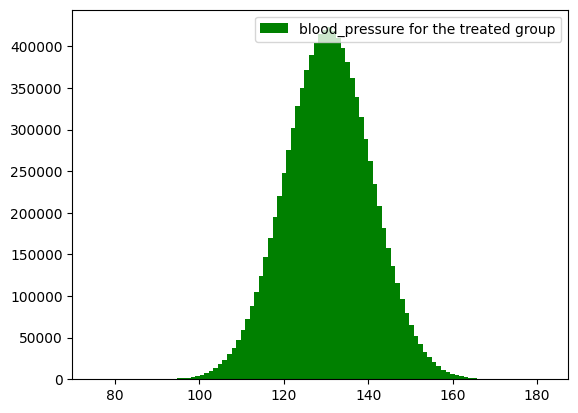

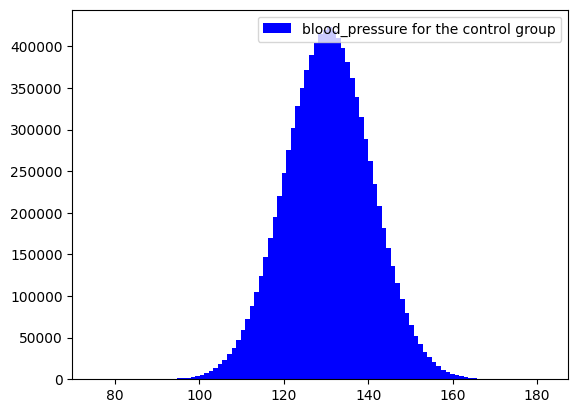

In [50]:
covariate_= 'blood_pressure'
data = df_treated[covariate_]
x_min = data.min()
x_max = data.max()
# Fixing bin edges
HIST_BINS = np.linspace(x_min, x_max, 100)
fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS,fc="green",label='blood_pressure for the treated group')
plt.legend(loc='upper right')
data = df_control[covariate_]
x_min = data.min()
x_max = data.max()
HIST_BINS = np.linspace(x_min, x_max, 100)
fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS,fc="blue",label='blood_pressure for the control group')
plt.legend(loc='upper right')
plt.show()

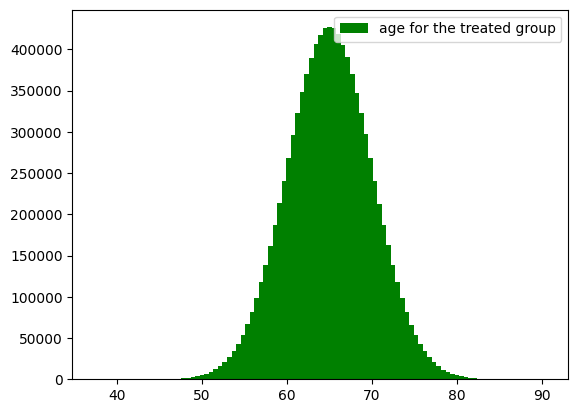

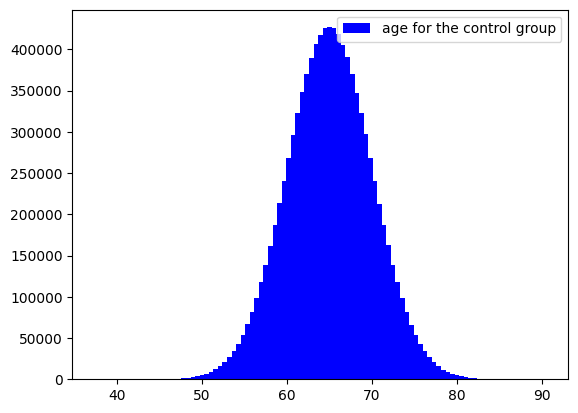

In [51]:
covariate_= 'age'
data = df_treated[covariate_]
x_min = data.min()
x_max = data.max()
# Fixing bin edges
HIST_BINS = np.linspace(x_min, x_max, 100)
fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS,fc="green",label='age for the treated group')
plt.legend(loc='upper right')

data = df_control[covariate_]
x_min = data.min()
x_max = data.max()
HIST_BINS = np.linspace(x_min, x_max, 100)
fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS,fc="blue",label='age for the control group')
plt.legend(loc='upper right')
plt.show()

In [52]:
def estimate_causal_effect(Xt, y, model=LinearRegression(), treatment_idx=0, regression_coef=False):
    model.fit(Xt, y)
    if regression_coef:
        return model.coef_[treatment_idx]
    else:
        Xt1 = pd.DataFrame.copy(Xt)
        Xt1[Xt.columns[treatment_idx]] = 1
        Xt0 = pd.DataFrame.copy(Xt)
        Xt0[Xt.columns[treatment_idx]] = 0
        return (model.predict(Xt1) - model.predict(Xt0)).mean()

In [53]:
ate_est_naive = estimate_causal_effect(binary_t_df[['sodium']], binary_t_df['blood_pressure'], treatment_idx=0)
print('Naive ATE estimate:\t\t\t\t\t\t\t', ate_est_naive)

Naive ATE estimate:							 5.328501680864975


In [54]:
ate_est_adjust_all = estimate_causal_effect(binary_t_df[['sodium', 'age', 'proteinuria']],binary_t_df['blood_pressure'], treatment_idx=0)
print('ATE estimate adjusting for all covariates:\t', ate_est_adjust_all)

ATE estimate adjusting for all covariates:	 0.8537946431496021


In [55]:
ate_est_adjust_age = estimate_causal_effect(binary_t_df[['sodium', 'age']], binary_t_df['blood_pressure'], treatment_idx=0)
print('ATE estimate adjusting for age:\t\t\t\t', ate_est_adjust_age)

ATE estimate adjusting for age:				 1.0502124539714488
